In [53]:
import numpy as np 
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import os
fnames = []
fpaths = []
for dirname, _, filenames in os.walk('Dataset'):
    for filename in filenames:
        fnames.append(filename.split('.')[0])
        fpaths.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))
        
# Initialize empty dictionary to store DataFrames
dfs = {}

# Read each file into a DataFrame
for name, path in zip(fnames, fpaths):
    dfs[name] = pd.read_csv(path, index_col=0, na_values=r'\N')

#Access the DataFrames using their filenames as keys in the dfs dictionary

circuits_df = dfs['circuits']
drivers_df = dfs['drivers']
constructors_df = dfs['constructors']
races_df = dfs['races']
pit_stops_df = dfs['pit_stops']
results_df = dfs['results']

print(results_df.shape)
print(pit_stops_df.head)

Dataset\circuits.csv
Dataset\constructors.csv
Dataset\constructor_results.csv
Dataset\constructor_standings.csv
Dataset\drivers.csv
Dataset\driver_standings.csv
Dataset\lap_times.csv
Dataset\pit_stops.csv
Dataset\qualifying.csv
Dataset\races.csv
Dataset\results.csv
Dataset\seasons.csv
Dataset\sprint_results.csv
Dataset\status.csv
(26080, 17)
<bound method NDFrame.head of         driverId  stop  lap      time duration  milliseconds
raceId                                                      
841          153     1    1  17:05:23   26.898         26898
841           30     1    1  17:05:52   25.021         25021
841           17     1   11  17:20:48   23.426         23426
841            4     1   12  17:22:34   23.251         23251
841           13     1   13  17:24:10   23.842         23842
...          ...   ...  ...       ...      ...           ...
1110           4     2   29  15:59:01   23.798         23798
1110         830     2   30  16:00:16   23.012         23012
1110         848

In [54]:
# Post-reading formatting
circuits_df = circuits_df.rename(columns={'name': 'circuitName', 'location': 'circuitLocation', 'country': 'circuitCountry', 'url': 'circuitUrl'})
drivers_df = drivers_df.rename(columns={'nationality': 'driverNationality', 'url': 'driverUrl'})
drivers_df['driverName'] = drivers_df['forename'] + ' ' + drivers_df['surname']
constructors_df = constructors_df.rename(columns={'name': 'constructorName', 'nationality': 'constructorNationality', 'url': 'constructorUrl'})
pit_stops_df = pit_stops_df.rename(columns={'time': 'pitTime'})
pit_stops_df['seconds'] = pit_stops_df['milliseconds'].apply(lambda x: x / 1000)
results_df['seconds'] = results_df['milliseconds'].apply(lambda x: x / 1000)


In [55]:
# Merge the DataFrames
newResults = pd.merge(results_df, races_df, left_on='raceId', right_index=True, how='left')
newResults = pd.merge(newResults, circuits_df, left_on='circuitId', right_index=True, how='left')
newResults = pd.merge(newResults, constructors_df, left_on='constructorId', right_index=True, how='left')
newResults = pd.merge(newResults, drivers_df, left_on='driverId', right_index=True, how='left')


newResults

# Merge the DataFrames
newPitStops = pd.merge(pit_stops_df, races_df, left_on='raceId', right_index=True, how='left')
newPitStops = pd.merge(newPitStops, circuits_df, left_on='circuitId', right_index=True, how='left')
newPitStops = pd.merge(newPitStops, newResults[['raceId','driverId','constructorId']], 
                       on=['raceId','driverId'])

newPitStops


# Merge newResults with aggregated newPitStops
raceResults = pd.merge(newResults, 
                       newPitStops.groupby(by=['raceId', 'driverId']).sum(), 
                       left_on=['raceId', 'driverId'], 
                       right_on=['raceId', 'driverId'], 
                       how='left')

# Calculate pitPercentage
raceResults['pitPercentage'] = raceResults['milliseconds_y'] / raceResults['milliseconds_x'] * 100

# Display the resulting DataFrame
print(raceResults.columns)
print(newResults.columns)
print(newPitStops.columns)

Index(['raceId', 'driverId', 'constructorId_x', 'number_x', 'grid', 'position',
       'positionText', 'positionOrder', 'points', 'laps', 'time_x',
       'milliseconds_x', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'seconds_x', 'year_x', 'round_x',
       'circuitId_x', 'name_x', 'date_x', 'time_y', 'url_x', 'fp1_date_x',
       'fp1_time_x', 'fp2_date_x', 'fp2_time_x', 'fp3_date_x', 'fp3_time_x',
       'quali_date_x', 'quali_time_x', 'sprint_date_x', 'sprint_time_x',
       'circuitRef_x', 'circuitName_x', 'circuitLocation_x',
       'circuitCountry_x', 'lat_x', 'lng_x', 'alt_x', 'circuitUrl_x',
       'constructorRef', 'constructorName', 'constructorNationality',
       'constructorUrl', 'driverRef', 'number_y', 'code', 'forename',
       'surname', 'dob', 'driverNationality', 'driverUrl', 'driverName',
       'stop', 'lap', 'pitTime', 'duration', 'milliseconds_y', 'seconds_y',
       'year_y', 'round_y', 'circuitId_y', 'name_y', 'date_y', 'time',

In [56]:
# Constructor color mapping
constructor_color_map = {
    'Mercedes':'#6CD3BF',
    'Red Bull':'#1E5BC6',
    'Ferrari':'#ED1C24',
    'McLaren':'#F58020',
    'Mercedes':'#6E0000',
    'Haas F1 Team':'#B6BABD',
    'Aston Martin':'#2D826D',
}


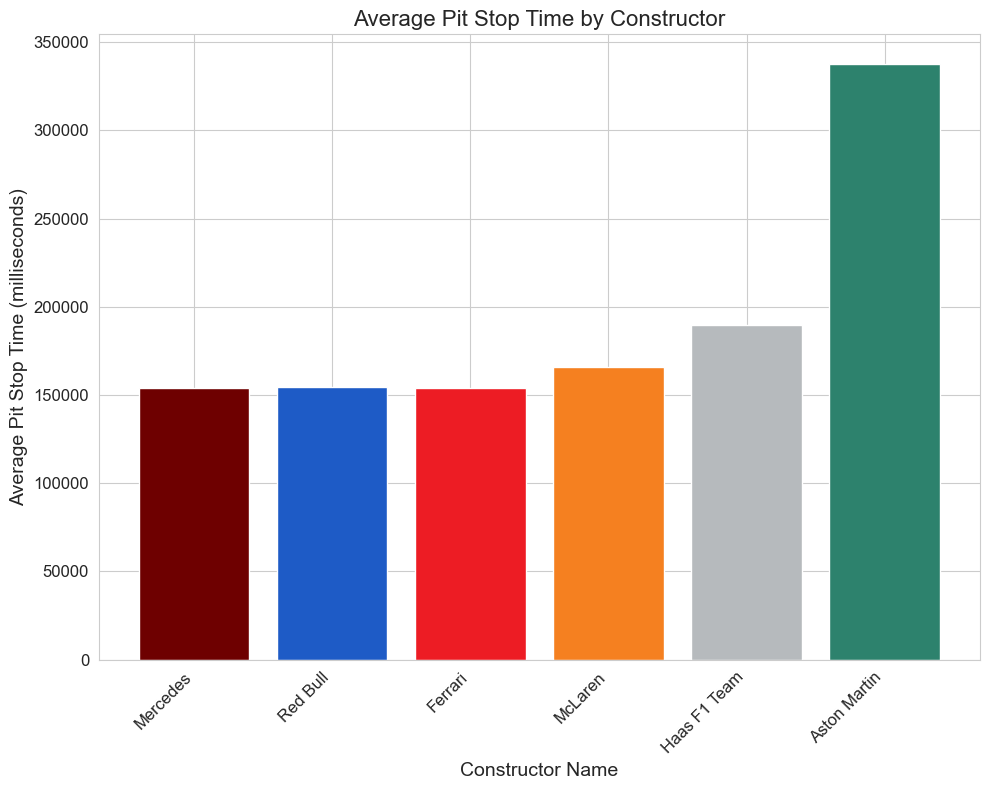

In [57]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame to include only rows with valid pit stop durations
valid_duration_df = raceResults[raceResults['milliseconds_y'].notnull()]

# Step 2: Group the filtered DataFrame by constructor name and calculate the average pit stop time
average_pit_stop_time = valid_duration_df.groupby('constructorName')['milliseconds_y'].mean()

# Step 3: Plotting with constructor colors
plt.figure(figsize=(10, 8))
for constructor, color in constructor_color_map.items():
    if constructor in average_pit_stop_time.index:
        plt.bar(constructor, average_pit_stop_time[constructor], color=color)

plt.xlabel('Constructor Name', fontsize=14)  # Increase font size
plt.ylabel('Average Pit Stop Time (milliseconds)', fontsize=14)  # Increase font size
plt.title('Average Pit Stop Time by Constructor', fontsize=16)  # Increase font size
plt.xticks(rotation=45, ha='right', fontsize=12)  # Increase font size
plt.yticks(fontsize=12)  # Increase font size
plt.tight_layout()
plt.show()



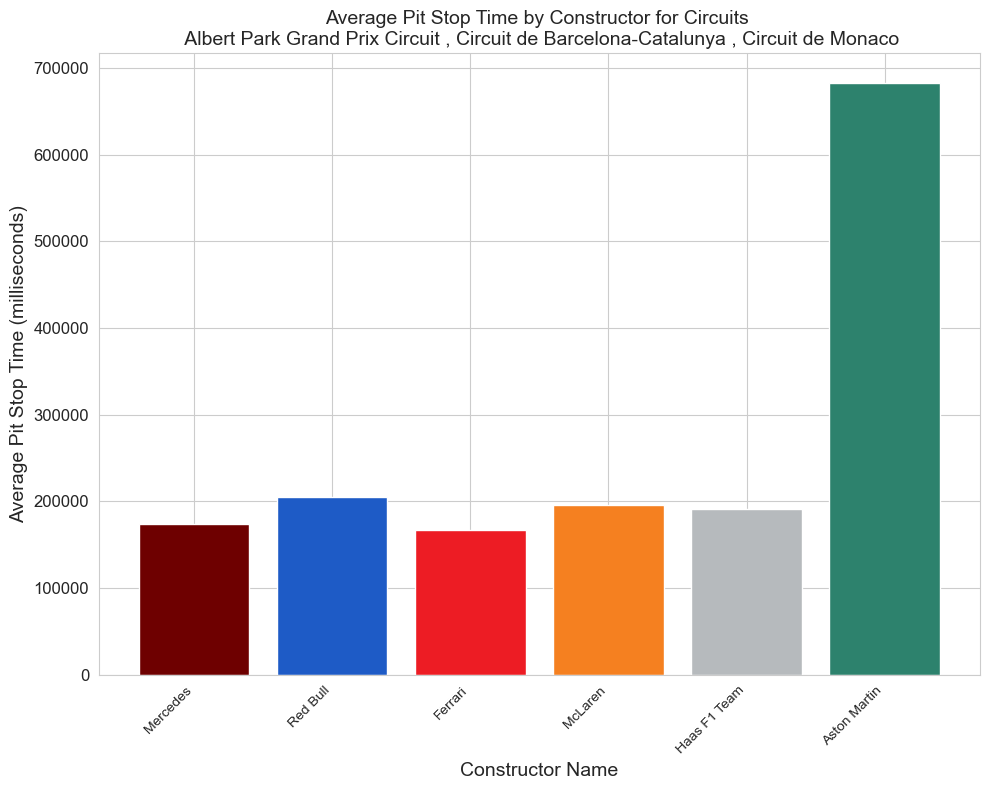

In [58]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame to include only rows with circuit IDs 1, 4, and 6
filtered_raceResults = raceResults[raceResults['circuitId_x'].isin([1, 4, 6])]

# Step 2: Filter the DataFrame to include only rows with valid pit stop durations
valid_duration_df = filtered_raceResults[filtered_raceResults['milliseconds_y'].notnull()]

# Step 3: Group the filtered DataFrame by constructor name and calculate the average pit stop time
average_pit_stop_time = valid_duration_df.groupby('constructorName')['milliseconds_y'].mean()

# Step 4: Plotting with constructor colors
plt.figure(figsize=(10, 8))
for constructor, color in constructor_color_map.items():
    if constructor in average_pit_stop_time.index:
        plt.bar(constructor, average_pit_stop_time[constructor], color=color)

plt.xlabel('Constructor Name',fontsize=14)
plt.ylabel('Average Pit Stop Time (milliseconds)',fontsize=14)
plt.title('Average Pit Stop Time by Constructor for Circuits \n Albert Park Grand Prix Circuit , Circuit de Barcelona-Catalunya , Circuit de Monaco',fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=12)  # Increase font size
plt.tight_layout()
plt.show()


In [59]:
import plotly.express as px

# Step 1: Filter the DataFrame to include only rows with the specified circuit IDs
specified_circuit_ids = [1, 4, 6]
filtered_newPitStops = newPitStops[newPitStops['circuitId'].isin(specified_circuit_ids)]

# Step 2: Filter the DataFrame to include only rows with valid pit stop durations
valid_duration_df = filtered_newPitStops[filtered_newPitStops['seconds'] < 50]
print(valid_duration_df)

# Step 3: Group the filtered DataFrame by race date and circuit ID and calculate the average pit stop duration for each race
average_pit_stop_time_per_circuit = valid_duration_df.groupby(['date', 'circuitName'])['seconds'].mean().reset_index()

circuit_names = ["Albert Park Grand Prix Circuit" , "Circuit de Barcelona-Catalunya" , "Circuit de Monaco"]


# Step 4: Create the line plot
fig = px.line(average_pit_stop_time_per_circuit, x='date', y='seconds', color='circuitName', 
              title='Average Pit Stop Duration Over Time for Specified Circuits',
              labels={'date': 'Date', 'seconds': 'Average Pit Stop Duration (seconds)', 'Circuit Name': 'circuitName'})

# Increase font size
fig.update_layout(
    font=dict(
        family="Arial",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()


      raceId  driverId  stop  lap   pitTime duration  milliseconds  seconds  \
0        841       153     1    1  17:05:23   26.898         26898   26.898   
1        841       153     2   17  17:31:06   24.463         24463   24.463   
2        841       153     3   35  17:59:45   26.348         26348   26.348   
3        841        30     1    1  17:05:52   25.021         25021   25.021   
4        841        30     2   17  17:32:08   23.988         23988   23.988   
...      ...       ...   ...  ...       ...      ...           ...      ...   
9891    1105       847     2   45  16:03:58   22.054         22054   22.054   
9892    1105       830     1   26  15:38:06   22.241         22241   22.241   
9893    1105       830     2   52  16:12:44   22.357         22357   22.357   
9894    1105       815     1   27  15:39:57   21.775         21775   21.775   
9895    1105       815     2   50  16:10:42   21.537         21537   21.537   

      year  round  ...  sprint_time   circuitRef  \

In [60]:
import plotly.express as px

# Filter pit stop data for circuit IDs 1, 4, and 6
filtered_pit_stops = newPitStops[newPitStops['circuitId'].isin([1, 4, 6]) & (newPitStops['seconds'] < 50)]

# Create the box plot with facets for each circuit
fig = px.box(filtered_pit_stops, y='seconds', facet_col='circuitId', 
             title='Distribution of Pit Stop Durations for Selected Circuits',
             labels={'seconds': 'Pit Stop Duration (seconds)', 'circuitId': 'Circuit ID'})

# Update layout with mean, 10th percentile, and 90th percentile annotations for each subplot
for i, circuit_id in enumerate([1, 4, 6]):
    data = filtered_pit_stops[filtered_pit_stops['circuitId'] == circuit_id]['seconds']
    mean_value = data.mean()
    percentile_10 = data.quantile(0.1)
    percentile_90 = data.quantile(0.9)
    fig.update_yaxes(title_text=f'Circuit {circuit_names[i]} \n Pit Stop Durations (seconds)', col=i+1)
    fig.add_hline(y=mean_value, col=i+1,
                  annotation_text=f"Mean: {mean_value:.2f}s", line_dash='solid', line_color='blue')
    fig.add_hline(y=percentile_10, col=i+1,
                  annotation_text=f"10th Percentile: {percentile_10:.2f}s", line_dash='dot', line_color='green')
    fig.add_hline(y=percentile_90, col=i+1,
                  annotation_text=f"90th Percentile: {percentile_90:.2f}s", line_dash='dot', line_color='red')

# Update title and annotation font sizes
fig.update_layout(
    margin = {"autoexpand" : True},
    title_font=dict(size=12),  # Increase title font size
    font=dict(size=10)  # Increase annotation font size
)

# Show the plot
fig.show()


In [61]:
import plotly.express as px

# Filter the data for race circuits 1, 4, and 6
filtered_data = newPitStops[newPitStops['circuitId'].isin([1, 4, 6]) & (newPitStops['seconds'] < 50)]

# Create the histogram
fig = px.histogram(filtered_data, x='seconds', color='circuitName', 
                   title='Pit Stop Duration Distribution by Circuit',
                   barmode='overlay')

# Add vertical lines for mean and quantiles
fig.add_vline(x=filtered_data['seconds'].mean(), 
              annotation_text=f"Average: {filtered_data['seconds'].mean():.2f}s", 
              annotation_position='top')
fig.add_vline(x=filtered_data['seconds'].quantile(0.1), 
              line_dash='dash', 
              annotation_text=f"Top Decile: {filtered_data['seconds'].quantile(0.1):.2f}s", 
              annotation_position='top left')
fig.add_vline(x=filtered_data['seconds'].quantile(0.9), 
              line_dash='dash', 
              annotation_text=f"Bottom Decile: {filtered_data['seconds'].quantile(0.9):.2f}s", 
              annotation_position='bottom right')

# Set opacity
fig.update_traces(opacity=0.9)

# Increase title font size
fig.update_layout(
    title_font=dict(size=25),
)

# Increase annotation font size
fig.update_annotations(font_size=14)

# Show the plot
fig.show()
